In [0]:
# Education - Udacity "Intro to TensorFlow for Deep Learning"
# Module: Forecasting with Convolutional Neural Network (WaveNet) Recurrent Neural Network
# REF: https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb

In [2]:
# Import packages.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt

# Using version 2.x of Tensorflow.
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Tensorflow.
import tensorflow as tf

# Print Tensorflow version.
print('TensorFlow Version:', tf.__version__)

TensorFlow 2.x selected.
TensorFlow Version: 2.1.0


In [0]:
# ====================
# Helper Function
# ====================
# Plot serie.
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)


# Trend.
def trend(time, slope=0):
  return slope * time


# Seasonal pattern.
def seasonal_pattern(season_time):
  # Just an arbitrary pattern.
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))


# Seasonality.
def seasonality(time, period, amplitude=1, phase=0):
  # Repeats the same pattern at each period.
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


# White noise.
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


# Sequence to sequence dataset.
def seq2seq_window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)


# Predict function.
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

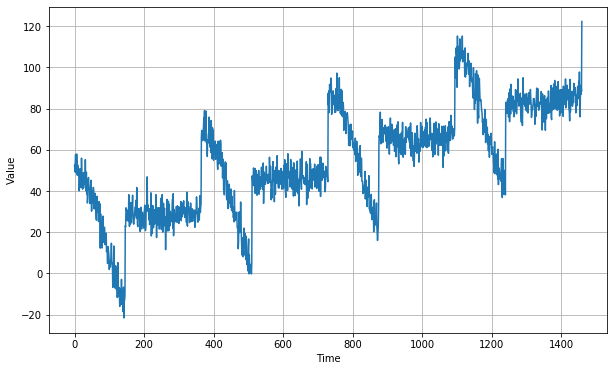

In [4]:
# Create dataset.
time      = np.arange(4 * 365 + 1)
slope     = 0.05
baseline  = 10
amplitude = 40
series    = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

noise_level = 5
noise       = white_noise(time, noise_level, seed = 42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Prepare for machine learning.
split_time    = 1000
time_train    = time[:split_time]
series_train  = series[:split_time]
time_valid    = time[split_time:]
series_valid  = series[split_time:]

In [6]:
# ==================
# 1D CNN (WaveNet) RNN Forecasting
# ==================
# Clear session, just useful under development, as we usually
# run the session multiple time in the notebook.
SEED        = 42
WINDOW_SIZE = 64
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

dataset_train = seq2seq_window_dataset(series_train, WINDOW_SIZE, batch_size = 128)

# Build the model with WaweNet architecture.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = [None, 1]))
for dr in (1, 2, 4, 8, 16, 32):
  model.add(
      tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1,
                             dilation_rate = dr, padding = "causal",
                             activation = "relu"
      )
  )
model.add(tf.keras.layers.Conv1D(filters = 1, kernel_size = 1))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30)
)
model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9),
  metrics = ["mae"]
)
history = model.fit(dataset_train, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 8s 940ms/step - loss: 42.1954 - mae: 42.7648
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 41.5801 - mae: 42.1354
Epoch 3/100
8/8 [==============================] - 0s 28ms/step - loss: 40.4527 - mae: 41.2189
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 38.6135 - mae: 39.4350
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 32.4558 - mae: 33.6242
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 19.6403 - mae: 19.9434
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 13.7136 - mae: 14.4993
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 9.3941 - mae: 9.8890
Epoch 9/100
8/8 [==============================] - 0s 22ms/step - loss: 8.1805 - mae: 8.7024
Epoch 10/100
8/8 [==============================] - 0s 23ms/step - loss: 7.3154 - mae: 7.7951
Epoch 11/100
8/8 [==============================] - 0s

[0.0001, 0.1, 0, 30]

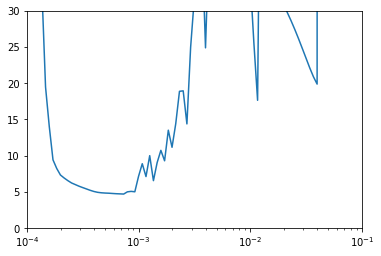

In [7]:
# Find the optimal learning rate.
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [0]:
# As we see that it would be safe to start with between 3e-4.

In [9]:
# Update model with the learning rate.
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

checkpoint_name = "cnn_wevenet_rnn_checkpoint.h5"
dataset_train   = seq2seq_window_dataset(series_train, WINDOW_SIZE, batch_size = 128)
dataset_valid   = seq2seq_window_dataset(series_valid, WINDOW_SIZE, batch_size = 128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = [None, 1]))
for dr in (1, 2, 4, 8, 16, 32):
  model.add(
      tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1,
                             dilation_rate = dr, padding = "causal",
                             activation = "relu"
      )
  )
model.add(tf.keras.layers.Conv1D(filters = 1, kernel_size = 1))
model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 3e-4, momentum = 0.9),
  metrics = ["mae"]
)

early_stopping    = tf.keras.callbacks.EarlyStopping(patience = 50)
model_checkpoint  = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, save_best_only = True)
model.fit(
  dataset_train,
  epochs = 500,
  validation_data = dataset_valid,
  callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/500
8/8 [==============================] - 2s 189ms/step - loss: 39.9926 - mae: 40.6674 - val_loss: 70.0941 - val_mae: 70.8419
Epoch 2/500
8/8 [==============================] - 0s 40ms/step - loss: 30.4261 - mae: 31.9064 - val_loss: 33.4391 - val_mae: 33.9305
Epoch 3/500
8/8 [==============================] - 0s 33ms/step - loss: 20.5348 - mae: 21.2613 - val_loss: 35.6967 - val_mae: 36.2327
Epoch 4/500
8/8 [==============================] - 0s 35ms/step - loss: 15.2570 - mae: 16.0884 - val_loss: 16.3702 - val_mae: 16.8614
Epoch 5/500
8/8 [==============================] - 0s 35ms/step - loss: 9.4565 - mae: 10.0879 - val_loss: 15.5621 - val_mae: 16.2034
Epoch 6/500
8/8 [==============================] - 0s 37ms/step - loss: 8.1709 - mae: 8.6358 - val_loss: 9.0863 - val_mae: 9.5033
Epoch 7/500
8/8 [==============================] - 0s 34ms/step - loss: 6.2738 - mae: 6.7675 - val_loss: 7.8004 - val_mae: 8.3794
Epoch 8/500
8/8 [==============================] - 0s 35ms/step - loss

In [0]:
# Load best model.
model = tf.keras.models.load_model(checkpoint_name)

In [11]:
# Forcast the model.
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]
rnn_forecast.shape

(461,)

MAE: 4.574532


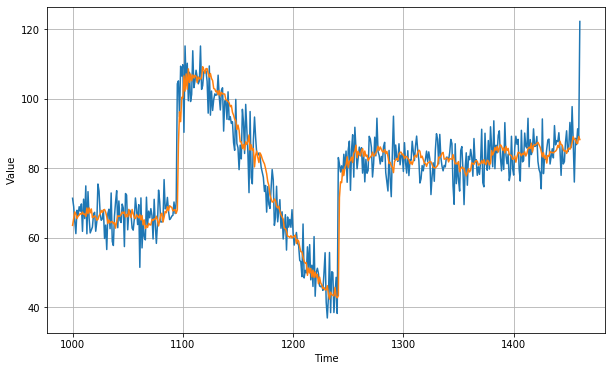

In [12]:
# Plot the forecast.
plt.figure(figsize = (10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

mae = tf.keras.metrics.mean_absolute_error(series_valid, rnn_forecast).numpy()
print("MAE:", mae)